# Vehicle Detection Project



The goals / steps of this project are the following:

    1) Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    2) Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
    3) Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
    4) Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    5) Estimate a bounding box for vehicles detected.


# Histogram of Oriented Gradients (HOG)

I added the feature extract code from class and critical libraries

In [60]:
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# from lesson_functions import *
from sklearn.model_selection import train_test_split
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
%matplotlib inline

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = file
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


I started by reading in all the vehicle and non-vehicle images. I added a code to save the data into a pickle file so that recurrent runs are easier to load: Here is an example of one of each of the vehicle and non-vehicle classes:

In [61]:


def data_gen():

    try:
        cars = pickle.load(open("cars.p", "rb"))
        y_cars = pickle.load(open("y_cars.p", "rb"))
        notcars = pickle.load(open("notcars.p", "rb"))
        y_notcars = pickle.load(open("y_notcars.p", "rb"))

        print('data exists')

        cars_shape = len(cars)
        notcars_shape = len(notcars)

        y_cars_shape = len(y_cars)
        y_notcars = len(y_notcars)

        print("Cars data shape =", cars_shape)
        print()
        print("Cars label data shape =", y_cars_shape)
        print ()

        print("Notcars data shape =", notcars_shape)
        print()
        print("Notcars label data shape =", y_notcars)
        print ()

    except (OSError, IOError) as e:
        ####################################################################
        # Divide up into cars and notcars
        cars = []
        notcars = []
        y_cars = []
        y_notcars = []
        start = time.time()

        images = glob.glob('vehicles/GTI_Far/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            cars.append(img)
            y_cars.append(1)

        images = glob.glob('vehicles/GTI_Left/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            cars.append(img)
            y_cars.append(1)

        images = glob.glob('vehicles/GTI_MiddleClose/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            cars.append(img)
            y_cars.append(1)

        images = glob.glob('vehicles/GTI_Right/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            cars.append(img)
            y_cars.append(1)


        images = glob.glob('vehicles/KITTI_extracted/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            cars.append(img)
            y_cars.append(1)


        images = glob.glob('non-vehicles/GTI/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            notcars.append(img)
            y_notcars.append(0)

        images = glob.glob('non-vehicles/Extras/*.png')
        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            notcars.append(img)
            y_notcars.append(0)

        cars = np.array(cars)
        notcars = np.array(notcars)
        y_cars = np.array(y_cars)
        y_notcars = np.array(y_notcars)

        pickle.dump(cars, open("cars.p", "wb"))
        pickle.dump(y_cars, open("y_cars.p", "wb"))
        pickle.dump(notcars, open("notcars.p", "wb"))
        pickle.dump(y_notcars, open("y_notcars.p", "wb"))
        print('NOT EXIST- DATA SAVED')

        end = time.time()




    return cars,y_cars, notcars,y_notcars



cars, y_cars, notcars, y_notcars = data_gen()


data exists
Cars data shape = 8792

Cars label data shape = 8792

Notcars data shape = 8968

Notcars label data shape = 8968



In [62]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):  # bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [65]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

print('features complete')


features complete


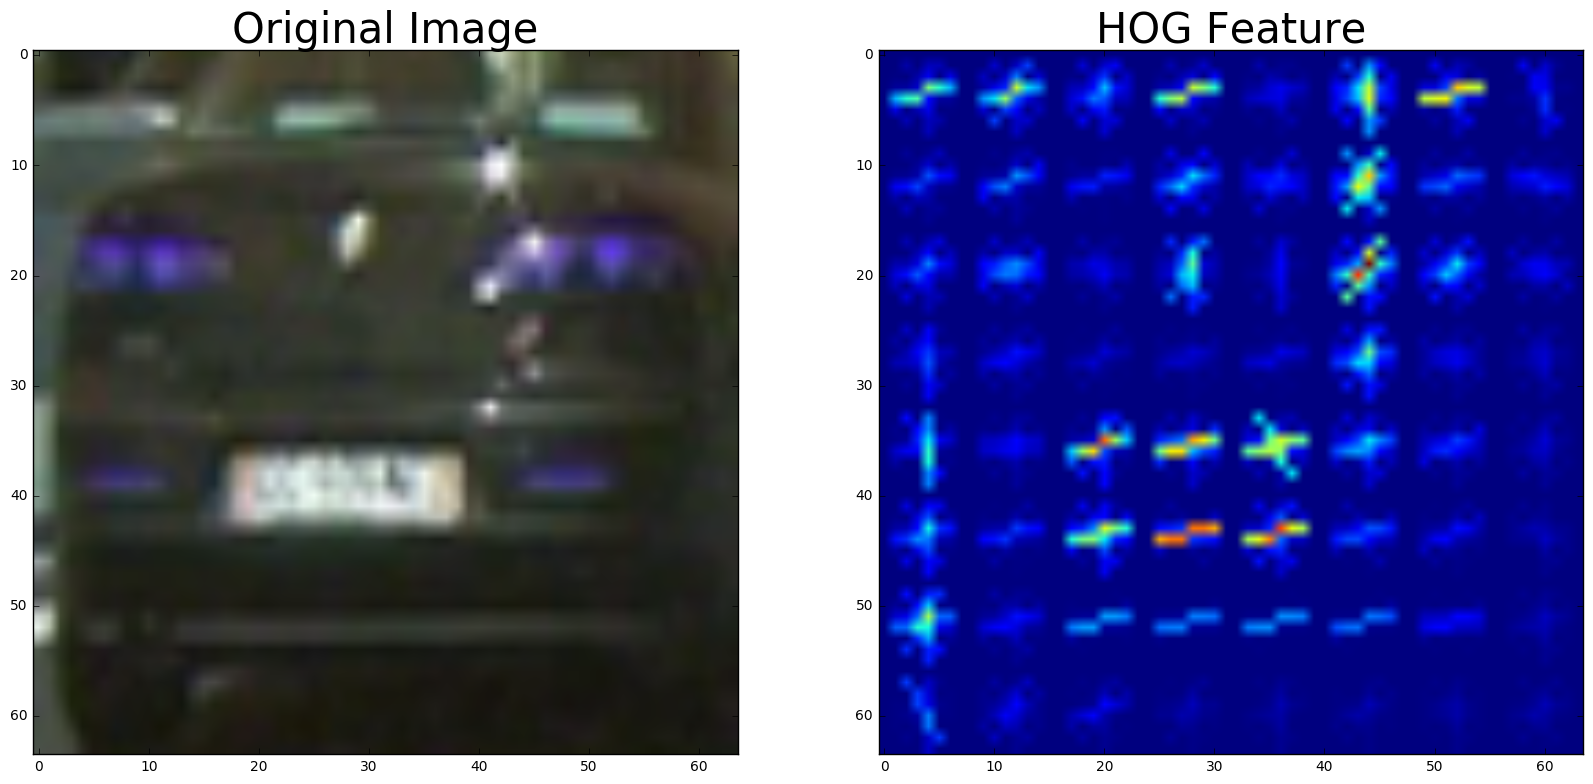

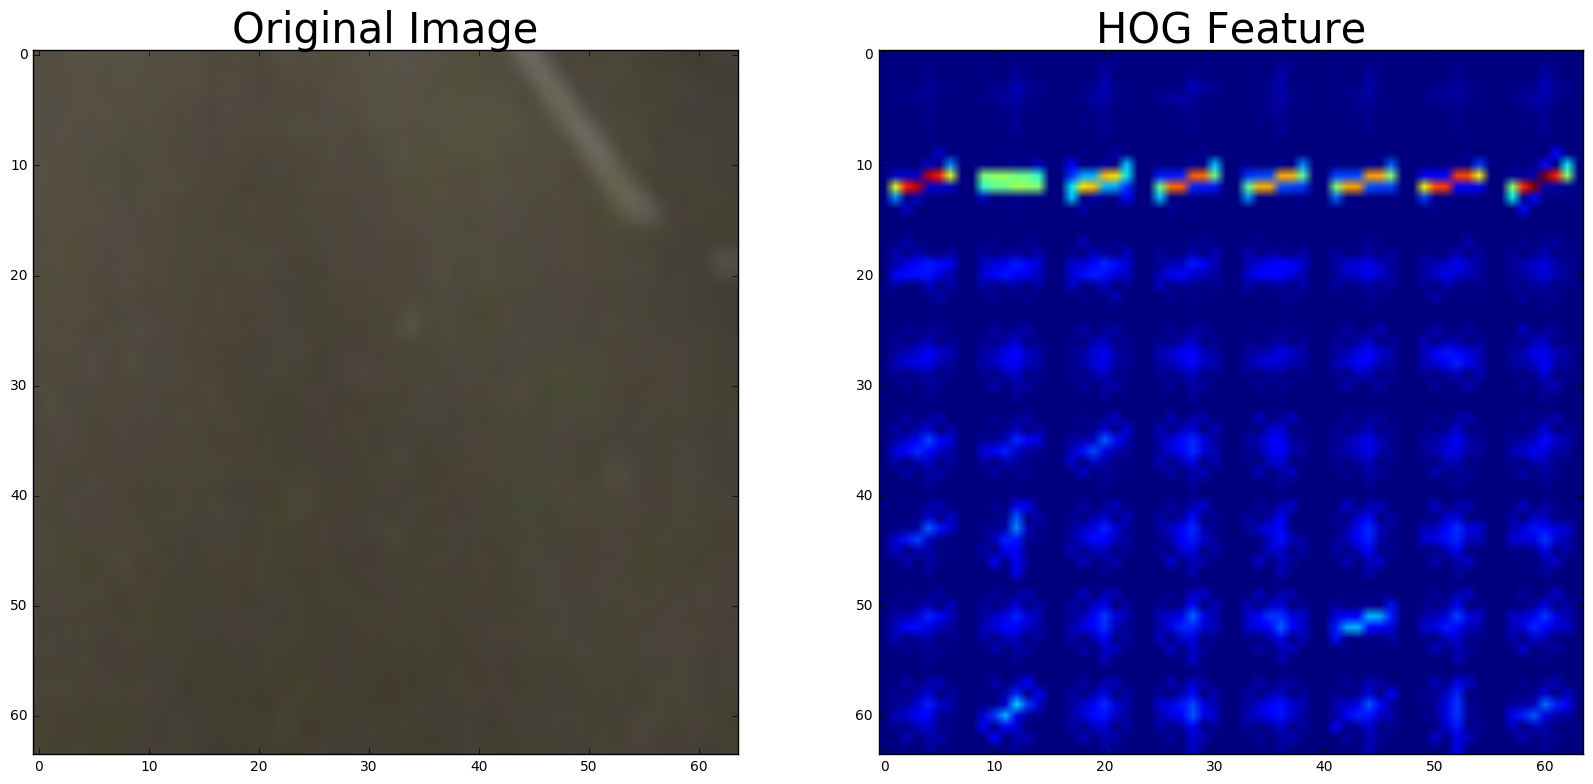

In [81]:
import random
index_cars = random.randrange(0, len(cars))
index_notcars = random.randrange(0,len(notcars))

not_needed,car_hog_image=  get_hog_features(cv2.cvtColor(cars[index_cars], cv2.COLOR_BGR2YCrCb)[:,:,0], orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

not_needed,notcars_hog_image=  get_hog_features(cv2.cvtColor(notcars[index_notcars], cv2.COLOR_BGR2YCrCb)[:,:,0], orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cars[index_cars])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(car_hog_image)
ax2.set_title('HOG Feature', fontsize=30)
plt.show()


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(notcars[index_cars])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(notcars_hog_image)
ax2.set_title('HOG Feature', fontsize=30)
plt.show()



I tried various combinations of parameters by trial and error. The main thing that effected the results was the color space, spatial size, and history bins. I kept all the features in the Linear SVM fit because its yielded the highest accuracy. The values I chose are shown above but I have put them below as well for easier reference:

In [82]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

I trained a linear SVM using the LinearSVC function built-into scikit. Originally, I tried using neural networks (keras) as well to fit the images. However, the SVM was clearly superior in terms of accuracy and time to fit. I also saved the values to pickle files. This allowed the manual iteration process to run a lot faster and smoother.

In [83]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

pickle.dump(X_scaler, open("X_scaler.p", "wb"))
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
pickle.dump(svc, open("svc.p", "wb"))
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
6.44 Seconds to train SVC...
Test Accuracy of SVC =  0.984


For the final sliding window search, I used the code that was provided from class. Also, I took the recommendation from class to use smaller windows near the horizon and larger windows closer to the car. This quicken the search signficantly but I got more false positives and was not reliable. I ended up searching three scales within a certain x and y range. This was extremely computationally expensive but was much more robust than the other methods I used. 

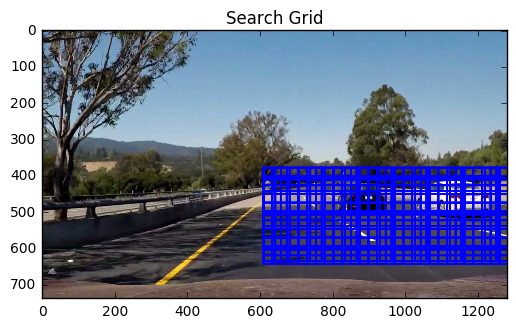

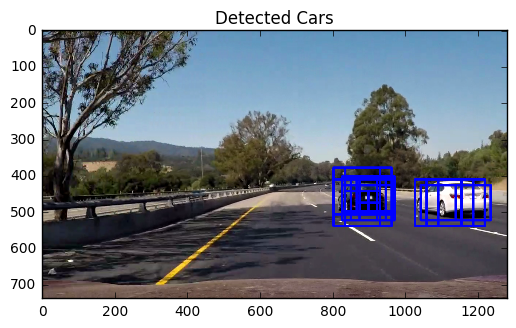

In [90]:
import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)



def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

image = mpimg.imread('test_images/test7.png' ,np.uint8)
# orig_image = mpimg.imread('test_images/test1.jpg' ,np.uint8)
# image= cv2.GaussianBlur(image, (5,5), 0)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

windows1 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows2 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows3 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))

# windows3 = slide_window(image, x_start_stop=[680, 1280], y_start_stop=y_start_stop,
#                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))

windows = windows1 + windows2 + windows3


hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)



window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)
plt.title('Search Grid')
plt.show()


window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)
plt.title('Detected Cars')
plt.show()

# Video Implementation

I used all the methods previous explained and used them into a video pipeline. Through the first couple iterations, the code created extremely wobbly and sporatic results. To correct for this, I implemented two methods into the code. The first method recorded the boxes from the previous three frames. When the current frame windows was calculated, I also inserted a certain randomly selected subsample of the previous boxes. Also, each previous frame had lower corresponding probability to reduce the effects from previous boxes. In addition, when I saved the previous frames, I also rejected any of the noise that was not in the current car boxes. The signficantly reduced the false positives and created a steady frame for the cars. 

In order to reduce redundancies and false positives, I used the heatmap function that was provided in class which detects how many boxes are within the certain region. If the amount of boxes is below the threshold, the boxes are rejected.

Below is the heatmap code provided from class:

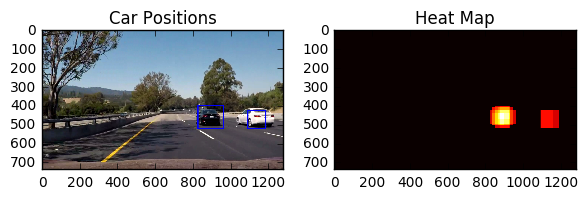

In [94]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_array = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_array.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img, bbox_array

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a
# list of boxes for one of the images shown above
box_list = hot_windows
heat = np.zeros_like(image[:, :, 0]).astype(np.float)





# Add heat to each box in box list
heat = add_heat(heat, box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, final_box = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()




Below is the code with the smooth and false positive filters applied in the video pipeline

In [97]:
import math
from moviepy.editor import VideoFileClip
import random


class box_param():

    def __init__(self):
        self.previous_boxes1 = []
        self.previous_boxes2 = []
        self.previous_boxes3 = []
        self.count = 0
        self.windows = []

        
def process_image(img):
    image = img
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image.astype(np.float32)/255

    windows1 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5))

    windows2 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                            xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows3 = slide_window(image, x_start_stop=[608, 1280], y_start_stop=[380, 656],
                            xy_window=(128, 128), xy_overlap=(0.75, 0.75))

    # windows3 = slide_window(image, x_start_stop=[680, 1280], y_start_stop=y_start_stop,
    #                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))

    # windows = windows1 + windows2 + windows3 + prev_box.previous_boxes1 + prev_box.previous_boxes2 + prev_box.previous_boxes3



    if prev_box.previous_boxes3 == []:
        windows = windows1 + windows2 + windows3 + prev_box.previous_boxes1 + prev_box.previous_boxes2 + prev_box.previous_boxes3
    elif prev_box.previous_boxes3 != [] and prev_box.count == 3:
        windows = windows1 + windows2 + windows3 + random.sample(prev_box.previous_boxes1,math.floor(len(prev_box.previous_boxes1)*1)) + random.sample(prev_box.previous_boxes2, math.floor(len(prev_box.previous_boxes2)*0.5)) + random.sample(prev_box.previous_boxes3,math.floor(len(prev_box.previous_boxes3)*0.1))
        prev_box.count = 0
    else:
        windows = prev_box.windows


    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)

    # window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    # plt.imshow(window_img)
    # plt.show()

    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a
    # list of boxes for one of the images shown above
    box_list = hot_windows
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives

    if prev_box.previous_boxes3 == []:
        heat = apply_threshold(heat, 3)
    else:
        heat = apply_threshold(heat, 3)


    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img, final_box = draw_labeled_bboxes(np.copy(image), labels)

    prev_box.windows = windows



    windows_temp = windows1 + windows2 + windows3
    export_box = []

    for box in windows_temp:
        box_center_x = (box[0][0] + box[1][0])/2
        box_center_y = (box[0][1] + box[1][1])/2
        for final_box_value in final_box:
            if box_center_x > final_box_value[0][0] and  box_center_x < final_box_value[1][0]:
                if box_center_y > final_box_value[0][1] and box_center_y < final_box_value[1][1]:
                    export_box.append(box)


    prev_box.previous_boxes3 = prev_box.previous_boxes2
    prev_box.previous_boxes2 = prev_box.previous_boxes1
    prev_box.previous_boxes1 = export_box
    prev_box.prev_img = draw_img
    prev_box.count += 1
    return draw_img

prev_box = box_param()
white_output = 'output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:07<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 



# Discussion

This project was much more challanging than I expected. The hardest part was to choose the correct parameter than gave good results. Too small and too many boxes would cause it to take over an hour to create the video. Too little makes it hard to detect the cars. Also, too large of a heatmap threshold does not track the car correctly. Too small of a threshold cause too many false positives. I've notciced the pipeline tends to have large amount of false positives near the car and it tends to not be able to detect the cars when they're further away. If I had more data, I would use a CNN instead of SVM since I believe this would make it more robust. I also want to try to running everything through a canny edge detect to see if it creates better results.